# Create a general MODFLOW model from the NHDPlus dataset

This notebook implements a grid-search approach to finding hydraulic conductivities that result in heads that seem reasonable.

Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as  cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cells up to the "Run to here" cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells.  Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [1]:
__author__ = 'Jeff Starn'
%matplotlib notebook
from model_specs import *
from gen_mod_dict import *

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import flopy as fp
import pandas as pd
import time
# import ipyparallel as ipp
# from model_specs import *
# from gen_mod_dict import *

from ipywidgets import interact, Dropdown
from IPython.display import display

The next cell is a template for making this notebook into a batch script. To do so, save this notebook as a .py file and edit it as follows. Comment out all the notebook-specific commands (drop-down menu stuff and commands preceded by %). Indent everything below the next cell twice so that it falls within the 'for' loop and the 'try' statement. Move the 'except' statement to the end of the script. Comment out lines in the cell after 'Preliminary stuff' so that the model is selected in the 'for' loop from gen_mod_dict. You can leave the print statement in that cell uncommented. 

In [2]:
for key, value in model_dict.items():   # from "gen_mod_dict.py"
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying Assabet
trying CoastalCT


In [3]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

### Run to here to initiate notebook

First time using this notebook in this session (before restarting the notebook), run the cells up to this point. Then select your model from the dropdown list above. Move your cursor to this cell and use the toolbar menu Cell --> Run All Below.  After the first time, if you want to run another model, select your model and start running from this cell--you don't need to re-run the cells from the beginning.

## Preliminary stuff

In [4]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}\n'.format(md))

The model being processed is CoastalCT



### Set observation weight here

Copy model to be calibrated (parent model) to new directory. Define the weight, which is used after all the models are run to find the best set of parameters by weighting the error rates. It is specified here so it can be used in the directory name. Weights > 1 result in fewer dry drains and more cells with heads above land surface. That tends to mean lower hydraulic conductivities.

In [4]:
hydro_wt = 1.
reuse_mag_par = True
restart = True

geo_ws = os.path.join(proj_dir, ms['ws'])
parent_ws = os.path.join(geo_ws, scenario_dir)
dir_name = '{}_cal_wt_{:4.2f}'.format(scenario_dir, hydro_wt)
model_ws = os.path.join(geo_ws, dir_name)

if os.path.exists(parent_ws):
    if (os.path.exists(model_ws)) & (not restart):
        shutil.rmtree(model_ws)
        shutil.copytree(parent_ws, model_ws)
    elif os.path.exists(model_ws) & restart:
        pass
    else:
        shutil.copytree(parent_ws, model_ws)
else:
    print('Parent model does not exist')

In [5]:
dst = os.path.join(model_ws, 'mf.bat')
with open(dst, 'w') as f:
    line = '{} {}.nam'.format(mfpth, md)
    f.write(line)

Load existing model and some packages needed for parameter estimation

In [6]:
nam_file = '{}.nam'.format(md)
mf = fp.modflow.Modflow.load(nam_file, version='mfnwt', exe_name=mfpth, 
                             verbose=False, model_ws=model_ws, load_only=None)

bas = mf.get_package('BAS6')
dis = mf.get_package('DIS')
upw = mf.get_package('UPW')
oc = mf.get_package('OC')
wel = mf.get_package('WEL')
head_file_pth = os.path.join(model_ws,'{}.hds'.format(md))

ibound = bas.ibound
botm = dis.getbotm()

In [7]:
#get the total well flux
wellData = wel.stress_period_data.to_array()['flux']
wellFluxTotal = np.sum(wellData[:]*ibound.array,axis=None)

Re-write nwt package with head tol = 0.001 for quicker convergence.

In [8]:
nwt = mf.get_package('NWT')
nwt.headtol = 0.001
mf.external_path = 'arrays'
mf.write_input()

Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:botm_layer_3: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:ibound_layer_3: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:strt_layer_3: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vani: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vani: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vani: resetting 'how' to ex

Read model_grid data frame created in notebook 1. 

In [9]:
model_file = os.path.join(geo_ws, 'model_grid.csv')
model_grid = pd.read_csv(model_file, na_values=[hnoflo, hdry])

obs_type = model_grid.obs_type
land_surface = model_grid.top

Read the zone array from the compressed zone file created in notebook 1.

In [10]:
zone_file = os.path.join(model_ws, 'zone_array.npz')
zones = np.load(zone_file)
zones = zones['zone']

### Define a few space-saving functions.

In [11]:
def make_par_grid(k_ar_f, k_ar_c, k_ar_b, k_ar_va):
    Kf, Kc, Kb, KVa = np.meshgrid( k_ar_f, k_ar_c, k_ar_b, k_ar_va )
    Kf, Kc, Kb, KVa = Kf.ravel(), Kc.ravel(), Kb.ravel(), KVa.ravel()
    index = Kf < Kc
    num_par = index.sum()
    par_grid = np.zeros((num_par, 13))
    par_grid[:, 0:4] = np.array((Kf[index], Kc[index], Kb[index], KVa[index])).T
    return par_grid

def new_k_arr(k, par_ar, num_k):
    index = np.arange(new_num_k)[par_ar == k]
    lo = par_ar[index - 1]
    hi = par_ar[index + 1]
    return np.logspace(np.log10(lo), np.log10(hi), num_k)

def make_par_df(par_grid, hydro_wt):
    par_df = pd.DataFrame.from_records(par_grid, columns=['Kf', 'Kc', 'Kb', 'vani', 'hydro', 
                                                          'topo', 'sse', 'p5', 'p10', 'p20', 'Best','RunTime','PumpFract'])
    par_df.dropna(axis='rows', inplace=True)
    par_df['diff_error'] = np.abs((par_df.hydro * hydro_wt) - par_df.topo)
    par_df['sum_error'] = par_df.hydro + par_df.topo

    # these lines implement the alternative algorithms 
#         tol = 0.20
#         ptol = 0.10    
#         reasonable = par_df[par_df.p10 < ptol]
#         h_min = par_df.loc[reasonable.hydro.argmin(), 'topo']
#         index = (par_df['topo'] <= (h_min * (1 + tol))) & (par_df['topo'] > (h_min * (1 - tol)))
#         best = par_df.loc[index, 'hydro'].argmin()
#         par_df.loc[best, 'Best'] = True

    # this line chooses parameters where fraction hydro errors ~ fraction topo errors
#     par_df.loc[par_df.diff_error.argmin(), 'Best'] = True
    
    # this code chooses the lowest difference error from the lowest 10% sum error.
    # the 'name' attribute grabs the line number (Pandas index)
    #assumes 0 error is a model error
    #assumes less than 98% pumping is an error
    target_magnitude = par_df.sum_error[par_df.sum_error>0].min() * 1.10
    par_df.loc[par_df.sum_error <= target_magnitude, 'Best'] = 'low_sum'
    par_df.loc[par_df.sum_error ==0,'Best']='error'
    #par_df.loc[par_df.PumpFract<0.98,'Best']="error"
    print(par_df)
    index = par_df.loc[par_df.Best == 'low_sum', :].diff_error[par_df.diff_error>0].argmin()
    par_df.loc[index, 'Best'] = 'low_diff'
    return par_df
        
def run_model1(k_):
    start_time = time.clock()
    import numpy as np
    import pandas as pd
    import os
    import flopy as fp
    import subprocess as sp
    
    def calc_error(top, head, obs_type):
    # an offset of err_tol is used to eliminate counting heads that
    # are within err_tol m of their target as errors.
        test_result = test_model(mf_lst_pth)
        if test_result[0]:
            # count topo and hydro errors
            t = top < (head - err_tol)
            h = top > (head + err_tol)

            tmp_df = pd.DataFrame({'head':head, 'ot':obs_type, 't':t, 'h':h})

            tmp = tmp_df.groupby('ot').sum()
            h_e_ = tmp.loc['hydro', 'h']
            t_e_ = tmp.loc['topo', 't']
            result = {1:np.array([h_e_, t_e_]),2:test_result[1]}
        else:
            result = {1:np.array([np.nan, np.nan]),2:np.nan}
        return result
   
    def write_K(K):
        nl = K.shape[0]
        for i in range(nl):
            name = os.path.join(model_ws, 'arrays', 'hk_layer_{}.ref'.format(i + 1))
            np.savetxt(name, K[i, :, :], fmt='%15.6E', delimiter='')  

    def write_V(V):
        nl = V.shape[0]
        for i in range(nl):
            name = os.path.join(model_ws, 'arrays', 'vani_layer_{}.ref'.format(i + 1))
            np.savetxt(name, V[i, :, :], fmt='%15.6E', delimiter='')  

# prepend wine to modflow executable if 'window' not in platform.platform().lower()

    def solve_heads(mfpth):
        beg = os.getcwd()
        os.chdir(model_ws)
        sp.call([mfpth, mf_nam])
        os.chdir(beg)
        hedf = fp.utils.HeadFile(head_file_pth)
        heads = hedf.get_data()
        # eliminate unrealistic heads that sometimes occur in isolated cells
        heads[heads > 1.E+29] = np.nan
        return heads

    def get_obs(heads):
        # make a 2D array of head in the highest active cell
        heads[heads == bas.hnoflo] = np.nan
        heads[heads == upw.hdry] = np.nan
        hin = np.argmax(np.isfinite(heads), axis=0)
        row, col = np.indices((hin.shape))
        h = heads[hin, row, col]
        return h.ravel()

    def test_model(mf_lst_pth, bad_run=10.0):
        #copy the list file for temporary review (until the next iteration finishes)
        shutil.copyfile(mf_lst_pth,mf_lst_pth.replace(".list","_temp.list"))
        
        # check that the model has a reasonable mass balance
        with open(mf_lst_pth) as fn:
            tmp = fn.readlines()
        line = [line.split() for line in tmp if 'PERCENT DISCREPANCY =' in line]
        perc_disc = float(line[0][3])
        if perc_disc > bad_run:
            print('Percent discrepancy for this run is bad and equals {}'.format(perc_disc))
            return [False]
        else:
            #check for convergence
            line = [line.split() for line in tmp if 'FAILED TO MEET SOLVER CONVERGENCE' in line]
            if len(line)>0:
                print('Failed to Converge')
                line = [line for line in tmp if 'WELLS = ' in line]
                line = line[1].split()[5]
                pumpFract = float(line) / (-1 * wellFluxTotal)
                return [True, pumpFract]
            else:
                #get the pumping fraction (less than 1 indicates pumping was reduced to avoid drying out the cells)
                line = [line for line in tmp if 'WELLS = ' in line]
                line = line[1].split()[5]
                pumpFract = float(line) / (-1 * wellFluxTotal)
                return [True, pumpFract]
    
    K = K_from_kvec.copy()
    K[zones == 0] = k_[0]
    K[zones == 1] = k_[1]
    K[zones == 3] = k_[2]
    write_K(K)

    V = np.ones(K.shape) * k_[3]
    write_V(V)

    heads = solve_heads(mfpth)
    yhat = get_obs(heads)

    e_ = calc_error(land_surface, yhat, obs_type)

    e = land_surface - yhat
    ew = e * w
    ew.dropna(inplace=True)
    sse = (ew.T).dot(ew)
    
    # write the array to text for return
    k_[4:6] = e_[1]
    k_[6] = sse
    k_[7] = np.float32((e) < -5.).sum() / num_cells
    k_[8] = np.float32((e) < -10.).sum() / num_cells
    k_[9] = np.float32((e) < -20.).sum() / num_cells
    k_[11] = time.clock() - start_time
    k_[12] = e_[2]

    k_[4] = k_[4] / num_hydro #+ (1.0-e_[2]) #this combines the errors from reduced pumping with the errors from dry rivers
    k_[5] = k_[5] / num_topo

    try:
        print("%s of %s runs complete"%(str(np.where(ref_par_grid[:,-1]>0)[0].shape[0]),str(ref_par_grid.shape[0])))
        mag_par_df = make_par_df(ref_par_grid, hydro_wt)
        dst = os.path.join(model_ws, 'par_ref_temp.csv')
        mag_par_df.to_csv(dst)
        
    except:
        print("%s of %s runs complete"%(str(np.where(mag_par_grid[:,-1]>0)[0].shape[0]),str(mag_par_grid.shape[0])))
        mag_par_df = make_par_df(mag_par_grid, hydro_wt)
        dst = os.path.join(model_ws, 'par_mag_temp.csv')
        mag_par_df.to_csv(dst)
        
    k_[6] = k_[6] / num_cells
    return k_

Replace entries from the default K_dict with the model specific K values from model_dict if they exist. 

In [12]:
for key, value in K_dict.items():
    if key in ms.keys():
        K_dict[key] = ms[key]

Use a dictionary to map K values to their zones.

In [13]:
kvec = {0 : K_dict['K_fine'], 1 : K_dict['K_coarse'], 2 : K_dict['K_lakes'], 3 : K_dict['K_bedrock']}

Create a K array using the default values from gen_mod_dict. A copy will be created in each iteration and the new K values substitued by zone. 

In [14]:
K_from_kvec = np.zeros_like(zones, dtype=np.float32)
for i, k in kvec.items():
    K_from_kvec[zones == i] = k

Weights (w) aren't used (in this version of the notebook) to select the best parameter sets.  Weights are only used to calculate the weighted sum of square residuals. SSWR is included for possible future use. Weights are the distance from a cell to the nearest drain divided by the maximum distance between a cell and a drain. The values range 0 to 1. 1 occurs at a drain; 0 occurs at the farthest point. The purpose is to give more weight to errors near a drain where we are most confident about the water level. 

The value hydro_weights ** is ** used, but by default is set to 1.  It is used to weight relative errors between hydro and topo errors. 

In [15]:
#temporarily removing this b/c calculating dist2str is giving errors in notebook 1
# w = model_grid.dist2str / model_grid.dist2str.max()
# w = 1 - w
w = 1

The numbers of each type of observation are used later to normalize error counts, resulting in fractional error rates.

In [16]:
num_hydro = obs_type.value_counts()['hydro']
num_topo = obs_type.value_counts()['topo']
num_cells = num_hydro + num_topo

## Run model parameter grid for order-of-magnitude estimates

Create an array of parameter values to try. The number of K values specified by num_k are created between p_min and p_max on a log scale. p_min and p_max are the base-10 exponents of K values. For example, np.logspace(-1, 2, 4) creates K values (0.1, 1.0, 10., 100.). All possible pairs of values are generated, then combinations where Kc < Kf are eliminated as being unrealistic. The K values can be created in any alternative way desired as long as the shape of par_grid is unchanged and the position (column) of the K values is unchanged. This procedure is repeated later in the notebook for a smaller range centered on the preliminary 'best' values.

* Kf is K fine
* Kc is K coarse
* Kb is K bedrock
* vani is vertical anisotropy

In [17]:
num_k = 4
new_num_k = num_k * 3 - 1
par_ar = np.logspace(-2, 3, new_num_k)

k_ar_f = par_ar[2 : -2 : 2]
k_ar_c = par_ar[2 : -2 : 2]
k_ar_b = par_ar[2 : -2 : 2] 
k_ar_va = par_ar[4 : -2 : 2]
# k_ar_f = np.array((1., 10., 100.0))
# k_ar_c = np.array((100.))
# k_ar_b = np.array((0.1))
# k_ar_va = np.array((10.))

mag_par_grid = make_par_grid(k_ar_f, k_ar_c, k_ar_b, k_ar_va)

Iterate through mag_par_grid and run the model for each set of parameters (using ```map```). Calculate different types of error and store them in mag_par_grid.

Re-write run_model so it is self-contained (internal imports, variables passed explicitly) the same way it would work in ipp. the function do_it should be similar to view.apply_async

In [18]:
mf_nam = mf.namefile
mf_lst_pth = mf.lst.fn_path
mf_nam = mf.namefile

In [20]:
# m = [run_model1(item) for item in mag_par_grid]

In [20]:
if reuse_mag_par:
    #need to find the order of magnitude results file
    mag_par_pth =  False
    dir_list = next(os.walk(geo_ws))[1]
    i = 0
    while not mag_par_pth and i<len(dir_list):
        thisDir = dir_list[i]
        if os.path.isfile(os.path.join(geo_ws,thisDir, 'par_mag.csv')):
            mag_par_pth = os.path.join(geo_ws,thisDir, 'par_mag.csv')
        i = 1 + i
    
    if not mag_par_pth:
        reuse_mag_par=False
    else:
        mag_par_grid = np.genfromtxt(mag_par_pth,delimiter=',', skip_header=1, usecols=list(range(1,mag_par_grid.shape[1]+1)))
        mag_par_df = make_par_df(mag_par_grid, hydro_wt)
        shutil.copy(mag_par_pth,os.path.join(geo_ws,model_ws, 'par_mag.csv'))
        m = [x for x in mag_par_grid[:]]
if not reuse_mag_par:
    startIter = next((i for i,j in enumerate(mag_par_grid[:,4]==0) if j),None)
    m = list(map(run_model1, mag_par_grid[startIter:,:]))
    #export the results from the order of magnitude calibration
    mag_par_df = make_par_df(mag_par_grid, hydro_wt)
    dst = os.path.join(model_ws, 'par_mag.csv')
    mag_par_df.to_csv(dst)
    #saves the order of magnitude results to the parent directory
    mag_par_df.to_csv(os.path.join(parent_ws, 'par_mag.csv'))
    
    #delete the temporary results file
    dst = os.path.join(model_ws, 'par_mag_temp.csv')
    os.remove(dst)


Convert par_grid to a data frame for easier manipulation.

The relative weight for hydro and topo observations is set near the top of the notebook. A value of 1 means that the best parameter set will result in the same fraction of hydro errors as topo errors. Weights greater than 1 favor higher K's. The 'root' variable is the weighted sum of topo and hydro errors.

Any combination of error measures can be used for model calibration. Here are two possibilities:

* Choose parameters that make the number of topo and hydro errors close
* Comment out last line to get
    * eliminate parameters where > 10% of cells have head > 10m above land surface AND
    * keep parameters within that group that are within 20% of the minimum number of hydro errors AND
    * choose parameters from within that group with the lowest topo error
    
There may be alternative parameters sets that are almost as good, compared to these criteria. Alternative parameter sets should also be investigated. Check the par.csv file.


## Run model parameter grid for refined estimates

Repeat model runs for parameters sets centered on the 'best' values from above. Expand the range using a log scale around the best value and follow the procedure as above. 
* Expand the range used above by one order of magnitude lower and higher
* Create intermediate log-scale values
* Use the intermediate values below (lo) and above (hi) the 'best' 
* Make new num_k values from lo to hi, centered on the 'best'

In [22]:
k_ = mag_par_df.loc[mag_par_df['Best'] == 'low_diff', ['Kf', 'Kc', 'Kb', 'vani']].values[0]

k_ar_f = new_k_arr(k_[0], par_ar, num_k)
k_ar_c = new_k_arr(k_[1], par_ar, num_k) 
k_ar_b = new_k_arr(k_[2], par_ar, num_k) 

if k_[3] == 1:
    k_ar_va = new_k_arr(k_[3], par_ar, 4)[-1:]
if k_[3] == 10:
    k_ar_va = new_k_arr(k_[3], par_ar, 2)
if k_[3] == 100:
    k_ar_va = new_k_arr(k_[3], par_ar, 2)

ref_par_grid = make_par_grid(k_ar_f, k_ar_c, k_ar_b, k_ar_va)

Run the model for all the parameter sets in par_grid.

In [23]:
ref_par_grid.shape

(120, 13)

New line below limits the amount of vertical anisotropy to 100.

In [24]:
ref_par_grid = ref_par_grid[ref_par_grid[:,3] <= 100, :]

In [25]:
ref_par_grid = np.genfromtxt(os.path.join(model_ws, 'par.csv'),delimiter=',', skip_header=1, usecols=list(range(1,ref_par_grid.shape[1]+1)))
ref_par_grid[np.isnan(ref_par_grid)]=0

In [36]:
# ref_par_grid = run_grid(ref_par_grid)
# make this data2
#if restart = True, first check for a temp results file, if it exists, then switch reuse_mag_par to False (if it isn't already)
if restart:
    ref_par_temp_pth = os.path.join(model_ws, 'par_ref_temp.csv')
    if os.path.exists(ref_par_temp_pth):
        ref_par_grid = np.genfromtxt(ref_par_temp_pth,delimiter=',', skip_header=1, usecols=list(range(1,ref_par_grid.shape[1]+1)))
        ref_par_grid[np.isnan(ref_par_grid)]=0
startIter = next((i for i,j in enumerate(ref_par_grid[:,4]==0) if j),None)
r = list(map(run_model1, ref_par_grid[startIter:,:]))

C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:97: RuntimeWarning: invalid value encountered in greater
C:\Users\jbarclay\.conda\envs\genmod\lib\site-packages\ipykernel\__main__.py:169: RuntimeWarning: invalid value encountered in greater


24 of 48 runs complete
           Kf          Kc        Kb      vani     hydro      topo  \
0    3.162278   31.622777  0.068129  3.162278  0.197509  0.358783   
1    3.162278   31.622777  0.146780  3.162278  0.218743  0.274629   
2    3.162278   31.622777  0.316228  3.162278  0.247641  0.189243   
3    6.812921   31.622777  0.146780  3.162278  0.225386  0.193027   
4    6.812921   31.622777  0.316228  3.162278  0.243417  0.139451   
5   14.677993   31.622777  0.316228  3.162278  0.254181  0.099110   
6    3.162278   68.129207  0.031623  3.162278  0.241898  0.412315   
7    3.162278   68.129207  0.146780  3.162278  0.221296  0.258858   
8    3.162278   68.129207  0.316228  3.162278  0.250359  0.174555   
9    6.812921   68.129207  0.031623  3.162278  0.183200  0.303783   
10   6.812921   68.129207  0.068129  3.162278  0.226565  0.242730   
11   6.812921   68.129207  0.146780  3.162278  0.240646  0.177374   
12   6.812921   68.129207  0.316228  3.162278  0.251625  0.125549   
13  14.6779

In [29]:
par_df = make_par_df(ref_par_grid, hydro_wt)

           Kf          Kc          Kb        vani     hydro      topo  \
0    0.100000    1.000000    0.100000    1.000000  0.013376  0.796602   
1    0.100000    1.000000    0.100000   10.000000  0.011505  0.820534   
2    0.100000    1.000000    0.100000  100.000000  0.008253  0.910682   
3    0.100000    1.000000    1.000000    1.000000  0.127627  0.206647   
4    0.100000    1.000000    1.000000   10.000000  0.112778  0.237671   
5    0.100000    1.000000    1.000000  100.000000  0.053812  0.451113   
6    0.100000    1.000000   10.000000   10.000000  0.341709  0.032018   
7    0.100000    1.000000   10.000000  100.000000  0.250989  0.136706   
8    0.100000    1.000000  100.000000   10.000000  0.522197  0.007700   
9    0.100000    1.000000  100.000000  100.000000  0.432428  0.069362   
10   0.100000   10.000000    0.100000    1.000000  0.023439  0.715549   
11   0.100000   10.000000    0.100000   10.000000  0.021414  0.740593   
12   0.100000   10.000000    0.100000  100.000000  

In [37]:
# par_grid = np.concatenate((mag_par_grid, ref_par_grid))
# par_df = make_par_df(par_grid, hydro_wt)

In [38]:
m.extend(r)
par_df = make_par_df(m, hydro_wt)

           Kf          Kc          Kb        vani     hydro      topo  \
0    0.100000    1.000000    0.100000    1.000000  0.271815  0.796602   
1    0.100000    1.000000    0.100000   10.000000  0.224933  0.820534   
2    0.100000    1.000000    0.100000  100.000000  0.290639  0.910682   
3    0.100000    1.000000    1.000000    1.000000  0.337041  0.206647   
4    0.100000    1.000000    1.000000   10.000000  0.327095  0.237671   
5    0.100000    1.000000    1.000000  100.000000  0.298474  0.451113   
6    0.100000    1.000000   10.000000   10.000000  0.545449  0.032018   
7    0.100000    1.000000   10.000000  100.000000  0.466998  0.136706   
8    0.100000    1.000000  100.000000   10.000000  0.828666  0.007700   
9    0.100000    1.000000  100.000000  100.000000  0.759265  0.069362   
10   0.100000   10.000000    0.100000    1.000000  0.174247  0.715549   
11   0.100000   10.000000    0.100000   10.000000  0.134132  0.740593   
12   0.100000   10.000000    0.100000  100.000000  

In [30]:
dst = os.path.join(model_ws, 'par.csv')
par_df.to_csv(dst)

#delete the temporary results file
dst = os.path.join(model_ws, 'par_ref_temp.csv')
os.remove(dst)

The model is run one final time with the 'best' parameters.

First re-set headtol to the original value of 0.0001

In [31]:
nwt = mf.get_package('NWT')
nwt.headtol = 0.0001
mf.external_path = 'arrays'
mf.write_input()

Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:botm_layer_3: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:ibound_layer_3: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:strt_layer_3: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vani: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vani: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vani: resetting 'how' to ex

In [32]:
k_ = par_df.loc[par_df['Best'] == 'low_diff', :'PumpFract'].values[0]

In [33]:
k_

array([14.67799267622069, 146.7799267622069, 0.14677992676220694,
       3.1622776601683795, 0.12001840773124711, 0.11152818991097922,
       114.4942572352375, 0.06752337616880844, 0.03404170208510426,
       0.010450522526126306, 'low_diff', 1936.012518, 0.8692416281746007], dtype=object)

In [34]:
run_model1(k_)

Failed to Converge
68 of 68 runs complete
           Kf          Kc          Kb        vani     hydro      topo  \
0    0.100000    1.000000    0.100000    1.000000  0.013376  0.796602   
1    0.100000    1.000000    0.100000   10.000000  0.011505  0.820534   
2    0.100000    1.000000    0.100000  100.000000  0.008253  0.910682   
3    0.100000    1.000000    1.000000    1.000000  0.127627  0.206647   
4    0.100000    1.000000    1.000000   10.000000  0.112778  0.237671   
5    0.100000    1.000000    1.000000  100.000000  0.053812  0.451113   
6    0.100000    1.000000   10.000000   10.000000  0.341709  0.032018   
7    0.100000    1.000000   10.000000  100.000000  0.250989  0.136706   
8    0.100000    1.000000  100.000000   10.000000  0.522197  0.007700   
9    0.100000    1.000000  100.000000  100.000000  0.432428  0.069362   
10   0.100000   10.000000    0.100000    1.000000  0.023439  0.715549   
11   0.100000   10.000000    0.100000   10.000000  0.021414  0.740593   
12   0.10

array([14.67799267622069, 146.7799267622069, 0.14677992676220694,
       3.1622776601683795, 0.12001840773124713, 0.11152818991097922,
       114.4942572352375, 0.067523376168808436, 0.034041702085104257,
       0.010450522526126306, 'low_diff', 982.730681, 0.86924162817460071], dtype=object)

In [35]:
f_hy = par_df.loc[par_df.Best == 'low_diff', 'hydro']
f_to = par_df.loc[par_df.Best == 'low_diff', 'topo']

K = K_from_kvec.copy()
K[zones == 0] = k_[0]
K[zones == 1] = k_[1]
K[zones == 3] = k_[2]

hedf = fp.utils.HeadFile(head_file_pth)
heads = hedf.get_data()
heads[heads == bas.hnoflo] = np.nan
heads[heads == upw.hdry] = np.nan
hin = np.argmax(np.isfinite(heads), axis=0)
row, col = np.indices((hin.shape))
h = heads[hin, row, col]
yhat = h.ravel()

Plot results.

C:\Users\jbarclay\.conda\envs\GenMod\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\jbarclay\.conda\envs\GenMod\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


<IPython.core.display.Javascript object>


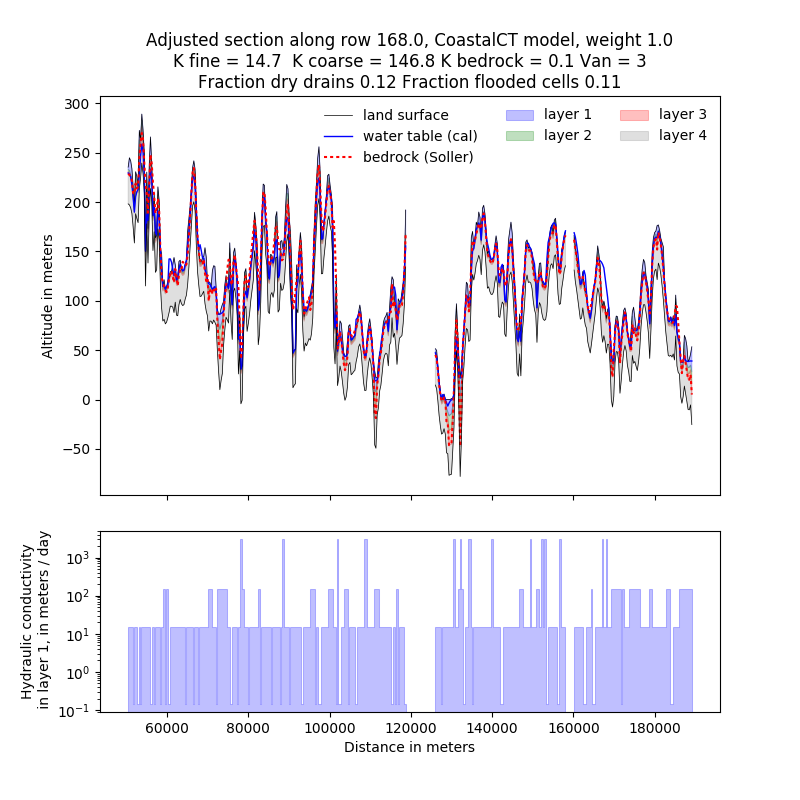

C:\Users\jbarclay\.conda\envs\GenMod\lib\site-packages\numpy\ma\core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
C:\Users\jbarclay\.conda\envs\GenMod\lib\site-packages\numpy\ma\core.py:3213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout._mask = _mask[indx]


In [36]:
imask = bas.ibound[:,:,:]

def ma2(data2D):
    return np.ma.MaskedArray(data2D, mask=(imask[0,:,:] == 0))

def ma3(data3D):
    return np.ma.MaskedArray(data3D, mask=(imask == 0))

row_to_plot = dis.nrow / 2
xplot = np.linspace( L / 2, dis.ncol * L - L / 2, dis.ncol)

mKh = ma3(K)
mtop = ma2(land_surface.reshape(dis.nrow, dis.ncol))
mbot = ma3(botm)
mbed = ma2(model_grid.kauffman_bedrock_el.reshape(dis.nrow, dis.ncol))
water_table_ma = ma2(yhat.reshape(dis.nrow, dis.ncol))
colors = ['green', 'red', 'gray']

fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot(xplot, mtop[row_to_plot, ], label='land surface', color='black', lw=0.5)
ax1.plot(xplot, water_table_ma[row_to_plot, ], label='water table (cal)', color='blue', lw=1.)
ax1.fill_between(xplot, mtop[row_to_plot, ], mbot[0, row_to_plot, :], alpha=0.25, 
                 color='blue', label='layer 1', lw=0.75)
for lay in range(dis.nlay - 1):
    label = 'layer {}'.format(lay+2)
    ax1.fill_between(xplot, mbot[lay, row_to_plot, :], mbot[lay+1, row_to_plot, :], label=label, 
                    color=colors[lay], alpha=0.250, lw=0.75)
ax1.plot(xplot, mbed[row_to_plot, :], label='bedrock (Soller)', color='red', linestyle='dotted', lw=1.5)
ax1.plot(xplot, mbot[-1, row_to_plot, :], color='black', linestyle='solid', lw=0.5)
ax1.legend(loc=0, frameon=False, fontsize=10, ncol=3)#, bbox_to_anchor=(1.0, 0.5))
ax1.set_ylabel('Altitude in meters')
ax1.set_xticklabels('')
ax1.set_title('Adjusted section along row {}, {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
 K bedrock = {:0.1f} Van = {:0.0f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format(row_to_plot, \
 md, hydro_wt, k_[0], k_[1], k_[2], k_[3], f_hy.values[0], f_to.values[0]))

ax2 = plt.subplot2grid((3, 1), (2, 0))
ax2.fill_between(xplot, 0, mKh[0, row_to_plot, :], alpha=0.25, color='blue', 
                 label='layer 1', lw=0.75, step='mid')
ax2.set_xlabel('Distance in meters')
ax2.set_yscale('log')
ax2.set_ylabel('Hydraulic conductivity\n in layer 1, in meters / day')

line = '{}_{}_xs_cal.png'.format(md, scenario_dir)
fig_name = os.path.join(model_ws, line)
plt.savefig(fig_name)
# plt.close()

A cross-section and 2D maps are made showing where errors occur. 

In [37]:
top, head, obs_type = land_surface, yhat, obs_type

t = top < (head - err_tol)
h = top > (head + err_tol)

mt = np.ma.MaskedArray(t.reshape(dis.nrow, dis.ncol), obs_type != 'topo')
mh = np.ma.MaskedArray(h.reshape(dis.nrow, dis.ncol), obs_type != 'hydro')

C:\Users\jbarclay\.conda\envs\GenMod\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\jbarclay\.conda\envs\GenMod\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


<IPython.core.display.Javascript object>


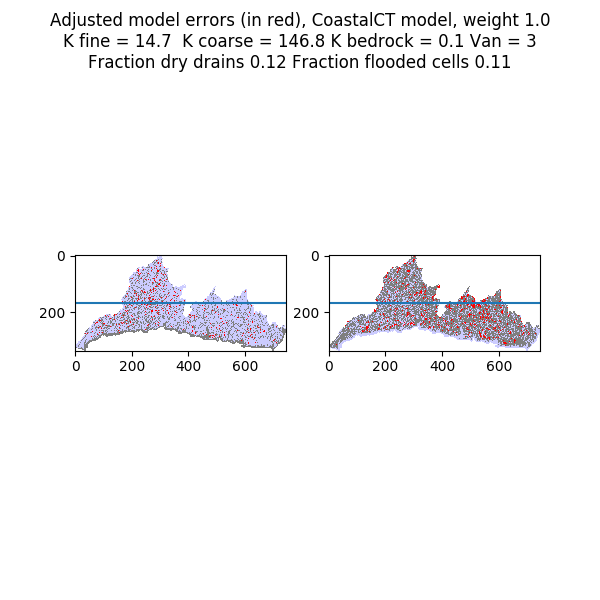

In [38]:
from matplotlib import colors

cmap = colors.ListedColormap(['0.50', 'red'])
cmap2 = colors.ListedColormap(['blue'])

back = np.ma.MaskedArray(ibound[0,:,:], ibound[0,:,:] == 0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(back, cmap=cmap2, alpha=0.2)
im0 = ax[0].imshow(mh, cmap=cmap, interpolation='None')
ax[0].axhline(row_to_plot)
# fig.colorbar(im0, ax=ax[0])
ax[1].imshow(back, cmap=cmap2, alpha=0.2)
im1 = ax[1].imshow(mt, cmap=cmap, interpolation='None')
ax[1].axhline(row_to_plot)
# fig.colorbar(im1, ax=ax[1])
# fig.suptitle('Adjusted model errors (in red) along row {}, {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
#  K bedrock = {:0.1f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format(row_to_plot, \
#  md, hydro_wt, k_[0], k_[1], k_[2], f_hy.values[0], f_to.values[0]))

fig.suptitle('Adjusted model errors (in red), {} model, weight {:0.1f}\nK fine = {:0.1f}  K coarse = {:0.1f}\
 K bedrock = {:0.1f} Van = {:0.0f}\nFraction dry drains {:0.2f} Fraction flooded cells {:0.2f}'.format( \
 md, hydro_wt, k_[0], k_[1], k_[2], k_[3], f_hy.values[0], f_to.values[0]))


# fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
#                       wspace=None, hspace=None)

fig.set_size_inches(6, 6)

line = '{}_{}_error_map_cal.png'.format(md, scenario_dir)
fig_name = os.path.join(model_ws, line)
plt.savefig(fig_name)
# plt.close()